# Efficiently sampling mixture models and their hierarchical latent variables with autodiff HMC

_Boris Leistedt, May 2017_

This notebook is available at [this location on Github](https://github.com/ixkael/Prob-tools/blob/master/notebooks/Efficiently%20sampling%20mixture%20models%20and%20their%20hierarchical%20latent%20variables%20with%20autodiff%20HMC.ipynb). 

We will consider the problem of efficiently inferring the parameters of mixture models. We will touch upon the following topics:
- density modelling with Gaussian mixtures
- parameter inference via an Ensemble sampler (emcee)
- dangerous degeneracies and a re-parametrization
- parameter inference via Hamiltonian Monte Carlo (HMC) 
- computing gradients and hessians with automatic differentiation
- sampling a large number of extra (hierarchical) latent variables 

This tutorial is by no means the final word on how to sample mixture models, it is merely a starting point. Possible extensions and improvements are listed at the end of the page.

### Requirements

Some basic knowledge of Bayes theorem, parameter inference via MCMC, and hierarchical probabilistic models.

You will need `matplotlib`, `scipy`, `numpy`, `autograd`, `emcee`

### Some useful references 

- Introduction to finite mixture models: https://arxiv.org/abs/1705.01505
- Extreme deconvolution, an alternative to sampling mixture models: https://arxiv.org/abs/0905.2979
- M. Betancourt's simplex-hypercube mapping: https://arxiv.org/abs/1010.3436
- Introduction to HMC: https://arxiv.org/abs/1206.1901
- Continuously tempered HMC method: https://arxiv.org/abs/1704.03338
- The Matrix Cookbook: http://www2.imm.dtu.dk/pubdb/views/publication_details.php?id=3274 
- The emcee sampler: http://dan.iel.fm/emcee/current

In [1]:
%matplotlib inline
%config IPython.matplotlib.backend = 'retina'
%config InlineBackend.figure_format = 'retina'

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rc
from cycler import cycler

import emcee
import corner

import autograd.numpy as np
from autograd.scipy.misc import logsumexp
from autograd import grad, hessian
import numpy as onp
from scipy.optimize import minimize
from scipy.misc import derivative

rc("font", family="serif", size=14)
rc("text", usetex=True)
matplotlib.rcParams['lines.linewidth'] = 2
matplotlib.rcParams['patch.linewidth'] = 2
matplotlib.rcParams['axes.prop_cycle'] =\
    cycler("color", ['k', 'c', 'm', 'y'])
matplotlib.rcParams['axes.labelsize'] = 16

## What are mixture models?

In the real of probabilistic models, mixture models are very common. They simply refer to describing a probabilty distribution a linear sum of components

$p(x) = \sum_i f_i K_i(x)$

The kernels usually belong to some family of probability distributions (e.g., Gaussians). One is usually interested in inferring the amplitude coefficients as well as the parameters of the kernels (e.g., their positions and sizes). Note that to obtain a valid probability distribution function (PDF) the amplitudes must be normalized, e.g., sum to one:

$\sum_i f_i = 1$

Note that in theory the kernels do not have to be identical or even belong to the same family. Also note that the mixture could be infinite. Both of those extensions are the state of the art of modern statistical modeling, but are advanced topics which will not be covered here.

You might have already realized that this loose definition gives a lot of flexibility but will also create numerous technical issues, notably in how mixture models are optimized or sampled when fitting data. In particular, note the infamous "label degeneracy", which refers to the ability to swap components/kernels and leave the total PDF invariant. This creates a lot of problems if one attempts to naively sample those parameters with MCMC. Luckily, there are standard tricks to get around this issue.

This notebook will just right into this question, and illustrate how to sample mixture models in nasty situations. For more background, please refer to the literature section above.

## Density modeling with Gaussian Mixtures

We will consider a set of $N$ points $\{x_i ; i=1,\cdots,N\}$ generated from the mixture of $B$ Gaussians, with amplitudes, means, and standard deviations denoted by $\vec{f},\vec{\beta}, \vec{\gamma}$. Thus, each $x_i$ is drawn from

$p(x_i|\vec{f},\vec{\beta}, \vec{\gamma}) = \sum_{b=1}^B f_b \mathcal{N}(x_i|\beta_b,\gamma^2_b)$

We use the notation $\mathcal{N}(x\vert\mu,\sigma^2) = (\sqrt{2\pi}\sigma)^{-1} \exp\left(-\frac{1}{2}\left(\frac{x-\mu}{\sigma}\right)^2\right)$

For each $x_i$, we observe a noisy version $y_i$, with Gaussian noise of standard deviation $\sigma_i$, such that

$p(y_i|x_i, \sigma_i) = \mathcal{N}(y_i|x_i,\sigma^2_i)$

Note that we work with the variables $f_b$ with $0 \leq f_b \leq 1$ and $\sum_{b=1}^B f_b = 1$, i.e., on the $B$-dimensional simplex. This is not convenient. That are ways to insure MCMC works in this context, but it is more robust to reparameterize the amplitudes. Among the many ways one could do this, that introduced by M. Betancourt (arxiv:1010.3436) is convenient and leads to simple derivatives. It simply maps the $(B-1)-$ hypercube onto the $B-$simplex, by constructing coefficients $z_i$'s with $0\leq z_i \leq 1$ for $i=1, \cdots, B-1$, and no normalization condition. The original coefficients on the simplex are found with

$f_b = \prod_{i=1}^{b-1} z_i  \cdot \left\{\begin{array}{ll}1-z_b &\mathrm{if\ }b < B \\ 1 &\mathrm{if\ } b = B \end{array}\right.$

We will now simulate a small data set and check that we can recover the parameters of the mixture used to make it.

In [2]:
def zs_to_alphas(zs):
    fac = np.concatenate((1 - zs, np.array([1])))
    zsb = np.concatenate((np.array([1]), zs))
    fs = np.cumprod(zsb) * fac
    return fs

nobj = 100 
nt = 2
zs = np.array([0.3])
alphas = zs_to_alphas(zs)
betas = np.array([0.35, 0.65])
betas.sort()
gammas = np.array([0.06, 0.06])
typecounts = np.random.multinomial(nobj, alphas)
types = np.concatenate([np.repeat(i, ni) for i, ni in enumerate(typecounts)]).astype(int)
xis = betas[types] + gammas[types] * np.random.randn(nobj) # Gaussian draws 
xis = np.array([betas[t] + gammas[t] * np.random.randn() for t in types]) # Gaussian draws 
sigmais = np.random.uniform(0.02, 0.1, size=nobj) 
yis = xis + sigmais * np.random.randn(nobj)  # Gaussian draws from N(x_i, sigma_i)
x_grid = np.linspace(0, 1, 100)
p_x_grid = alphas[None, :] * np.exp(-0.5*((x_grid[:, None] - betas[None, :])/gammas[None, :])**2)/\
    np.sqrt(2*np.pi)/gammas[None, :]

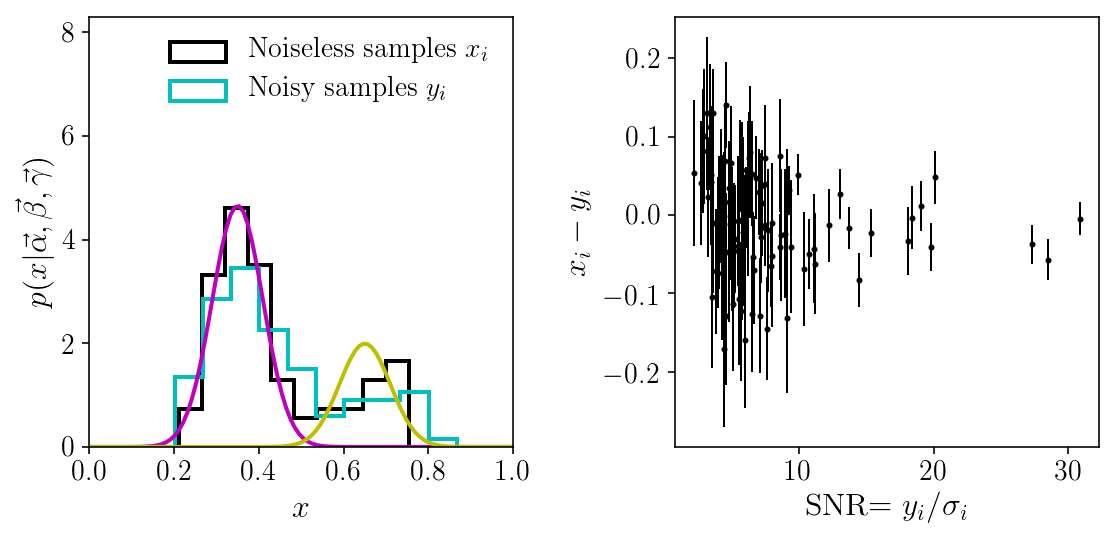

In [3]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
axs[0].hist(xis, histtype='step', normed=True,
           label=r'Noiseless samples $x_i$')
axs[0].hist(yis, histtype='step', normed=True,
           label=r'Noisy samples $y_i$')
for t in range(nt):
    axs[0].plot(x_grid, p_x_grid[:, t])
axs[0].legend(frameon=True).get_frame().set_linewidth(0)
axs[0].set_xlim([0, 1])
axs[0].set_ylim([0, axs[0].get_ylim()[1]*1.7])
axs[0].set_ylabel(r'$p(x|\vec{\alpha}, \vec{\beta}, \vec{\gamma})$')
axs[0].set_xlabel(r'$x$')
axs[1].errorbar(yis/sigmais, xis-yis, sigmais, fmt="o", lw=1, markersize=2)
axs[1].set_xlabel(r'SNR$=y_i/\sigma_i$')
axs[1].set_ylabel(r'$x_i-y_i$')
fig.tight_layout()

As we can see, our noisy samples span a wider domain than the initial density. Because of the noise, the density is blurried, and we cannot resolve the two components. In fact, we barely guess that there are two components. But, as we will see below, because the noise is known, is can be deconvolved, and we can recover the two components pretty well.

Let us now write the posterior distribution of the parameters of this model. We are interested in recovering $\vec{f},\vec{\beta}, \vec{\gamma}$ from the noisy data and their errors, $\{y_i, \sigma_i\}$. Unfortunately, the noiseless values $\{ x_i \}$ are not observed; they must be modeled and marginalized over. By applying Bayes' theorem twice and introducing latent $x_i$'s, we can write the posterior distribution of interest:

$p(\vec{f},\vec{\beta}, \vec{\gamma} | \{y_i, \sigma_i\}) \propto p(\vec{f},\vec{\beta}, \vec{\gamma}) \prod_{i=1}^N \int \mathrm{d}x_i p(y_i|x_i, \sigma_i)p(x_i|\vec{f},\vec{\beta}, \vec{\gamma})$

We have dropped the evidence at the denominator, since it is a normalization constant. It would be important if we were comparing models or fitting parameters accross models. For parameter estimation within one model (here with two components), it is unimportant.

By making the distributions explicit, our full posterior distribution reads

$p(\vec{f},\vec{\beta}, \vec{\gamma} | \{y_i, \sigma_i\})\propto p(\vec{f},\vec{\beta}, \vec{\gamma}) \prod_{i=1}^N  \sum_{b=1}^B f_b \int  \mathrm{d}x_i\mathcal{N}(x_i|\beta_b,\gamma^2_b)\mathcal{N}(y_i|x_i,\sigma^2_i)$

However, notice that we are in a very special context: both our distribution model and our likelihood are Gaussian. In other words, we are in presence of a product of Gaussians being integrated over. This can be resolved analytically, and leads to

$p(\vec{f},\vec{\beta}, \vec{\gamma} | \{y_i, \sigma_i\}) \propto p(\vec{f},\vec{\beta}, \vec{\gamma}) \prod_{i=1}^N \sum_{b=1}^B f_b \mathcal{N}(y_i|\beta_b,\sigma^2_i + \gamma^2_b)$

If you are note sure how to do that, please look at the Matrix Cookbook! The reference is above.

This is a very convenient result since we have once and for all removed the latent variables and integrals, and we obtained a simple expression for the posterior distribution of interest. We will refer to this expression as the "simplified" posterior, while the previous one, with the set of latent variables and integrals, is the "full" posterior. 

Minor comment: we have integrated each $x_i$ in $[-\infty, \infty]$, but we will adopt bounded priors $[0,1]$ in the other numerical tests below. This difference does not affect our investigations. If we wanted to be very precise, we could easily include truncated gaussians in the simplified likelihood.

We will try sampling both of those posterior distributions below. This is because in many real-world problems this analytic simplification is not possible, and one has to work with the full posterior distribution, which might involve many latent variables and integrals. This would be the case if our population model and/or our noise were not Gaussian. We will work with this toy model because we have the simplified posterior distribution to verify our results.

In [4]:
# Let's first define a few basic functions we will need.
def alphaszs_jacobian(fs, zs):
    jaco = np.zeros((zs.size, fs.size))
    for j in range(fs.size):
        for i in range(zs.size):
            if i < j:
                jaco[i, j] = fs[j] / zs[i]
            if i == j:
                jaco[i, j] = fs[j] / (zs[j] - 1)
    return jaco

def gaussian(x, mu, sig):
    return np.exp(-0.5*((x - mu)/sig)**2) / np.sqrt(2*np.pi) / sig

def gaussian_gradmu(x, mu, sig):
    return - gaussian(x, mu, sig) * (x - mu)/sig**2

def gaussian_gradsig(x, mu, sig):
    return - gaussian(x, mu, sig) / sig + gaussian(x, mu, sig) * (x - mu)**2/sig**3

def gaussiansumsig(x, mu, sig1, sig2):
    sig = np.sqrt(sig1**2 + sig2**2)
    return gaussian(x, mu, sig)
    
def gaussiansumsig_gradsig1(x, mu, sig1, sig2):
    sig = np.sqrt(sig1**2 + sig2**2)
    return gaussian_gradsig(x, mu, sig) * sig1 / sig

def lngaussian(x, mu, sig):
    return - 0.5*((x - mu)/sig)**2 - 0.5*np.log(2*np.pi) - np.log(sig)

def lngaussian_gradmu(x, mu, sig):
    return (x - mu) / sig**2

def lngaussian_gradsig(x, mu, sig):
    return (x - mu)**2 / sig**3 - 1. / sig 
    
# Let's also define a convenient function for testing gradients and derivatives.
# We compare the analytic prediction to the numerical derivative.
def test_derivative(x0, fun, fun_grad, relative_accuracy, n=1, lim=0, order=9, dxfac=0.01,
                    verbose=False, superverbose=False):
    grads = fun_grad(x0)
    for i in range(x0.size):
        if verbose:
            print(i, end=" ")
        def f(v):
            x = 1*x0
            x[i] = v
            return fun(x)
        grads2 = derivative(f, x0[i], dx=dxfac*x0[i], order=order, n=n)
        if superverbose:
            print(i, grads2, grads[i])
        if np.abs(grads2) >= lim:
            onp.testing.assert_allclose(grads2, grads[i],
                                       rtol=relative_accuracy)

In [5]:
# The simplified posterior distribution is easy to code up:
def lnprob_hyperonly1(params):
    alphas, betas, gammas = params[0:nt], params[nt:2*nt], params[2*nt:3*nt]
    alphas /= np.sum(alphas)  # to enforce the normalization
    likes = np.log(alphas[None, :]) +\
        lngaussian(yis[:, None], betas[None, :], 
                   np.sqrt(gammas[None, :]**2. + sigmais[:, None]**2.))
    return - np.sum(logsumexp(likes, axis=1))

## First MCMC : raw model

Let us sample the simplified posterior distribution (which, for our fake data set, has 6 parameters) with a very good sampler: emcee. The reasons why emcee is a good sampler are beyond the scope of this tutorial (but scale invariance and speed are two good reasons!). As mentioned before, we adopt uniform priors. Rather than taking priors in $[0,1]$, we will use $[0.03, 0.97]$. This is to avoid a trans-dimensional multimodal distribution, as discussed in the last section of this page.

In [6]:
def lnprob(params):  # log posterior distribution to be given to emcee
    alphas, betas, gammas = params[0:nt], params[nt:2*nt], params[2*nt:3*nt]
     # some reasonnable parameter bounds
    if np.any(alphas < 0.1) or np.any(alphas > 0.9):
        return -np.inf 
    if np.any(params <= 0.03) or np.any(params >= 0.97): 
        return -np.inf
    return - lnprob_hyperonly1(params)

params = np.concatenate([alphas, betas, gammas])
ndim = params.size
nwalkers = ndim * 30

# initial set of walkers
p0s = []
for i in range(nwalkers):
    lnp = -np.inf
    while ~np.isfinite(lnp):
        p0 = np.random.uniform(0.03, 0.97, ndim) 
        p0[0:nt] /= np.sum(p0[0:nt])
        #p0[0:nt].sort()
        #p0[0:nt] = p0[0:nt][::-1]
        #p0[nt:2*nt].sort()
        lnp = lnprob(p0)
    p0s += [p0]

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, threads=4)
pos, prob, state = sampler.run_mcmc(p0s, 1000)
sampler.reset()
_ = sampler.run_mcmc(pos, 1000)

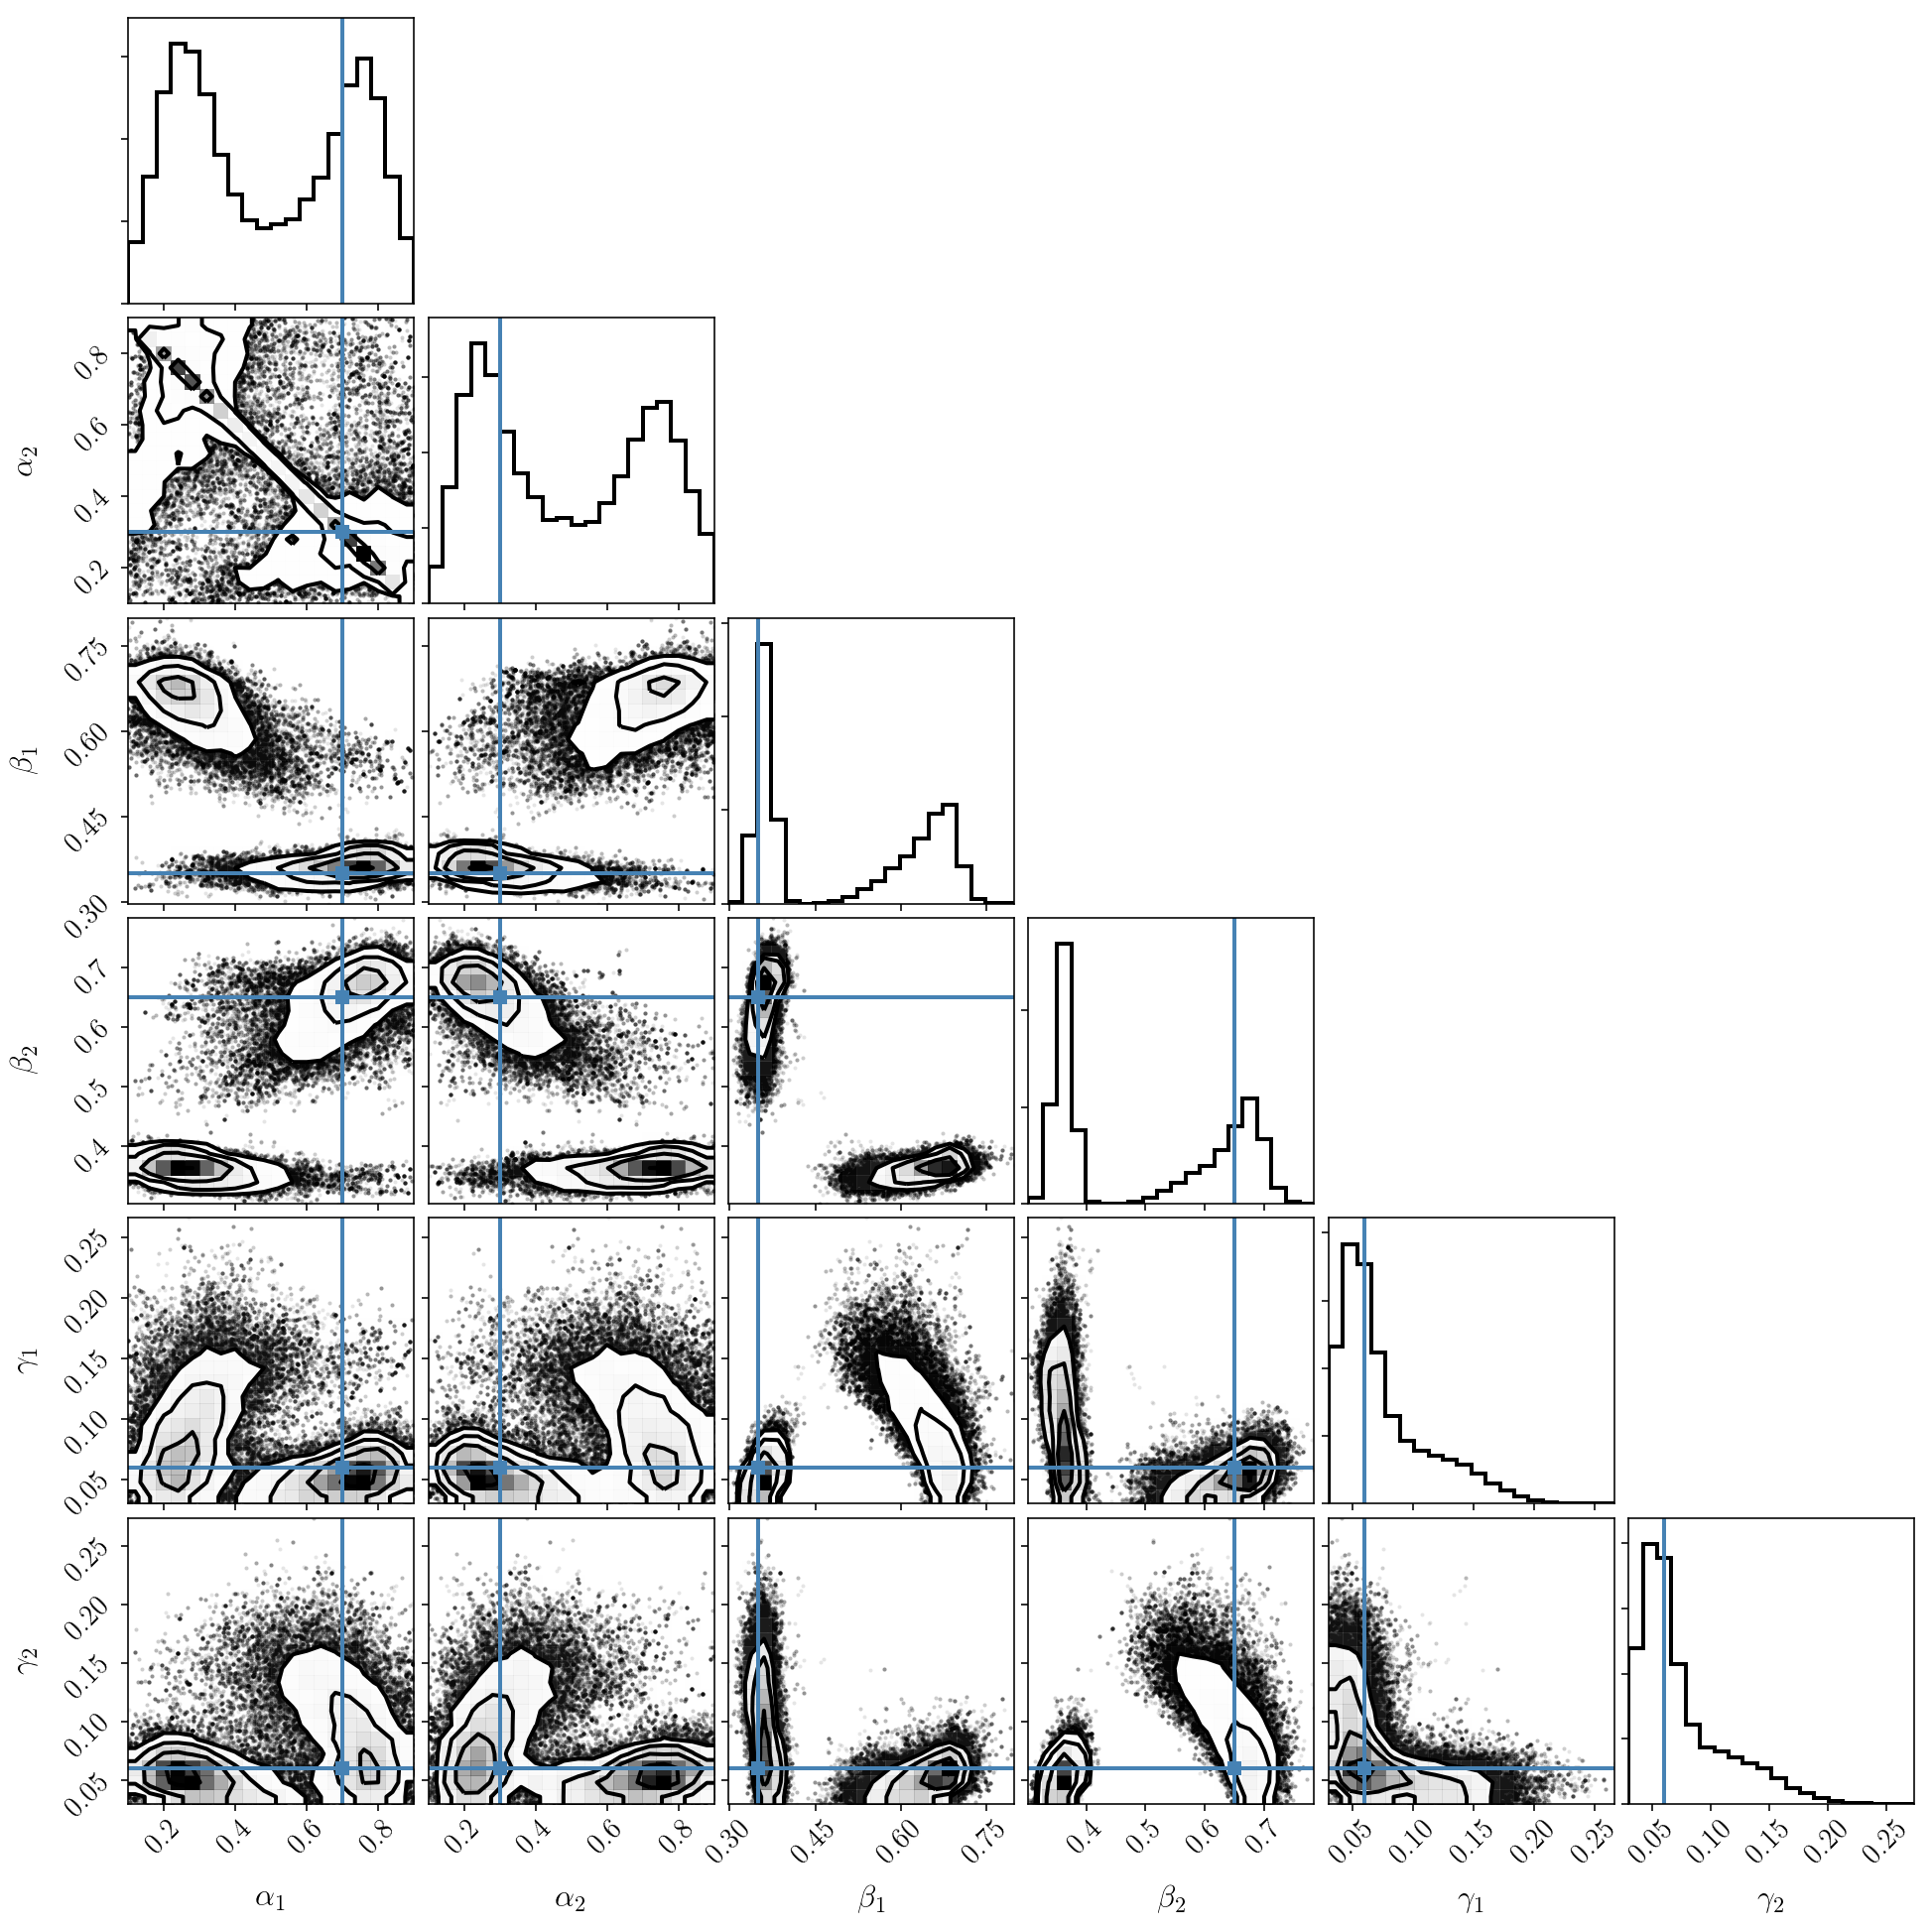

In [7]:
param_names = [r'$\alpha_'+str(i+1)+'$' for i in range(nt)] +\
    [r'$\beta_'+str(i+1)+'$' for i in range(nt)] +\
    [r'$\gamma_'+str(i+1)+'$' for i in range(nt)]
_ = corner.corner(sampler.flatchain, truths=params, labels=param_names)

As we can see, the result is surprisingly nasty! In fact, running MCMC on this distribution is *incorrect*. The sampler probably hasn't converged despite many iterations. The posterior distribution has strong degeneracies and is multimodal, so standard MCMC will not work.

We mentioned that phenomenon before. The degeneracy between $\alpha$'s is due to them being normalized. Since we cannot impose this constraint in emcee, we have simply normalized them manually in each function call. However, this lead to a degeneracy: one can multiply the $\alpha$'s by an arbitrary constant and obtain the same value of the posterior distribution. This explains the thin axis degeneracy we observe in the first panel. As mentioned before, a clean way to solve this issue is to reparametrize the amplitudes. We use the hypercube-to-simplex mapping described above.

Moreover, we haven't imposed a specific order to the components, which means they can be swapped and lead to the same value of the posterior distribution. This label switching degeneracy is well known and leads to a perfectly multimodal distribution. While a common solution is to post process the chain to order the components, this still interferes with the stability of the sampler, so it is better to simply enforce the order of the components (for example their $\beta$'s) in the prior itself. This is the solution we adopt.

## Second MCMC run: emcee with reparametrized model

In [8]:
def lnprob(params):
    zs, betas, gammas = params[0:nt-1], params[nt-1:2*nt-1], params[2*nt-1:3*nt-1]
    if np.any(zs < 0.1) or np.any(zs > 0.8):
        return -np.inf
    alphas = zs_to_alphas(zs)
    for i in range(nt-1):
        if betas[i] >= betas[i+1]:
            return -np.inf
    if np.any(params <= 0.03) or np.any(params >= 0.9):
        return -np.inf
    return - lnprob_hyperonly1(np.concatenate((alphas, params[nt-1:])))

params = np.concatenate([zs, betas, gammas])
ndim = params.size
nwalkers = ndim * 30
p0s = []
for i in range(nwalkers):
    lnp = -np.inf
    while ~np.isfinite(lnp):
        p0 = np.random.uniform(0.03, 0.9, ndim) 
        p0[nt-1:2*nt-1].sort()
        lnp = lnprob(p0)
    p0s += [p0]

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, threads=4)
pos, prob, state = sampler.run_mcmc(p0s, 1000)
sampler.reset()
_ = sampler.run_mcmc(pos, 1000)

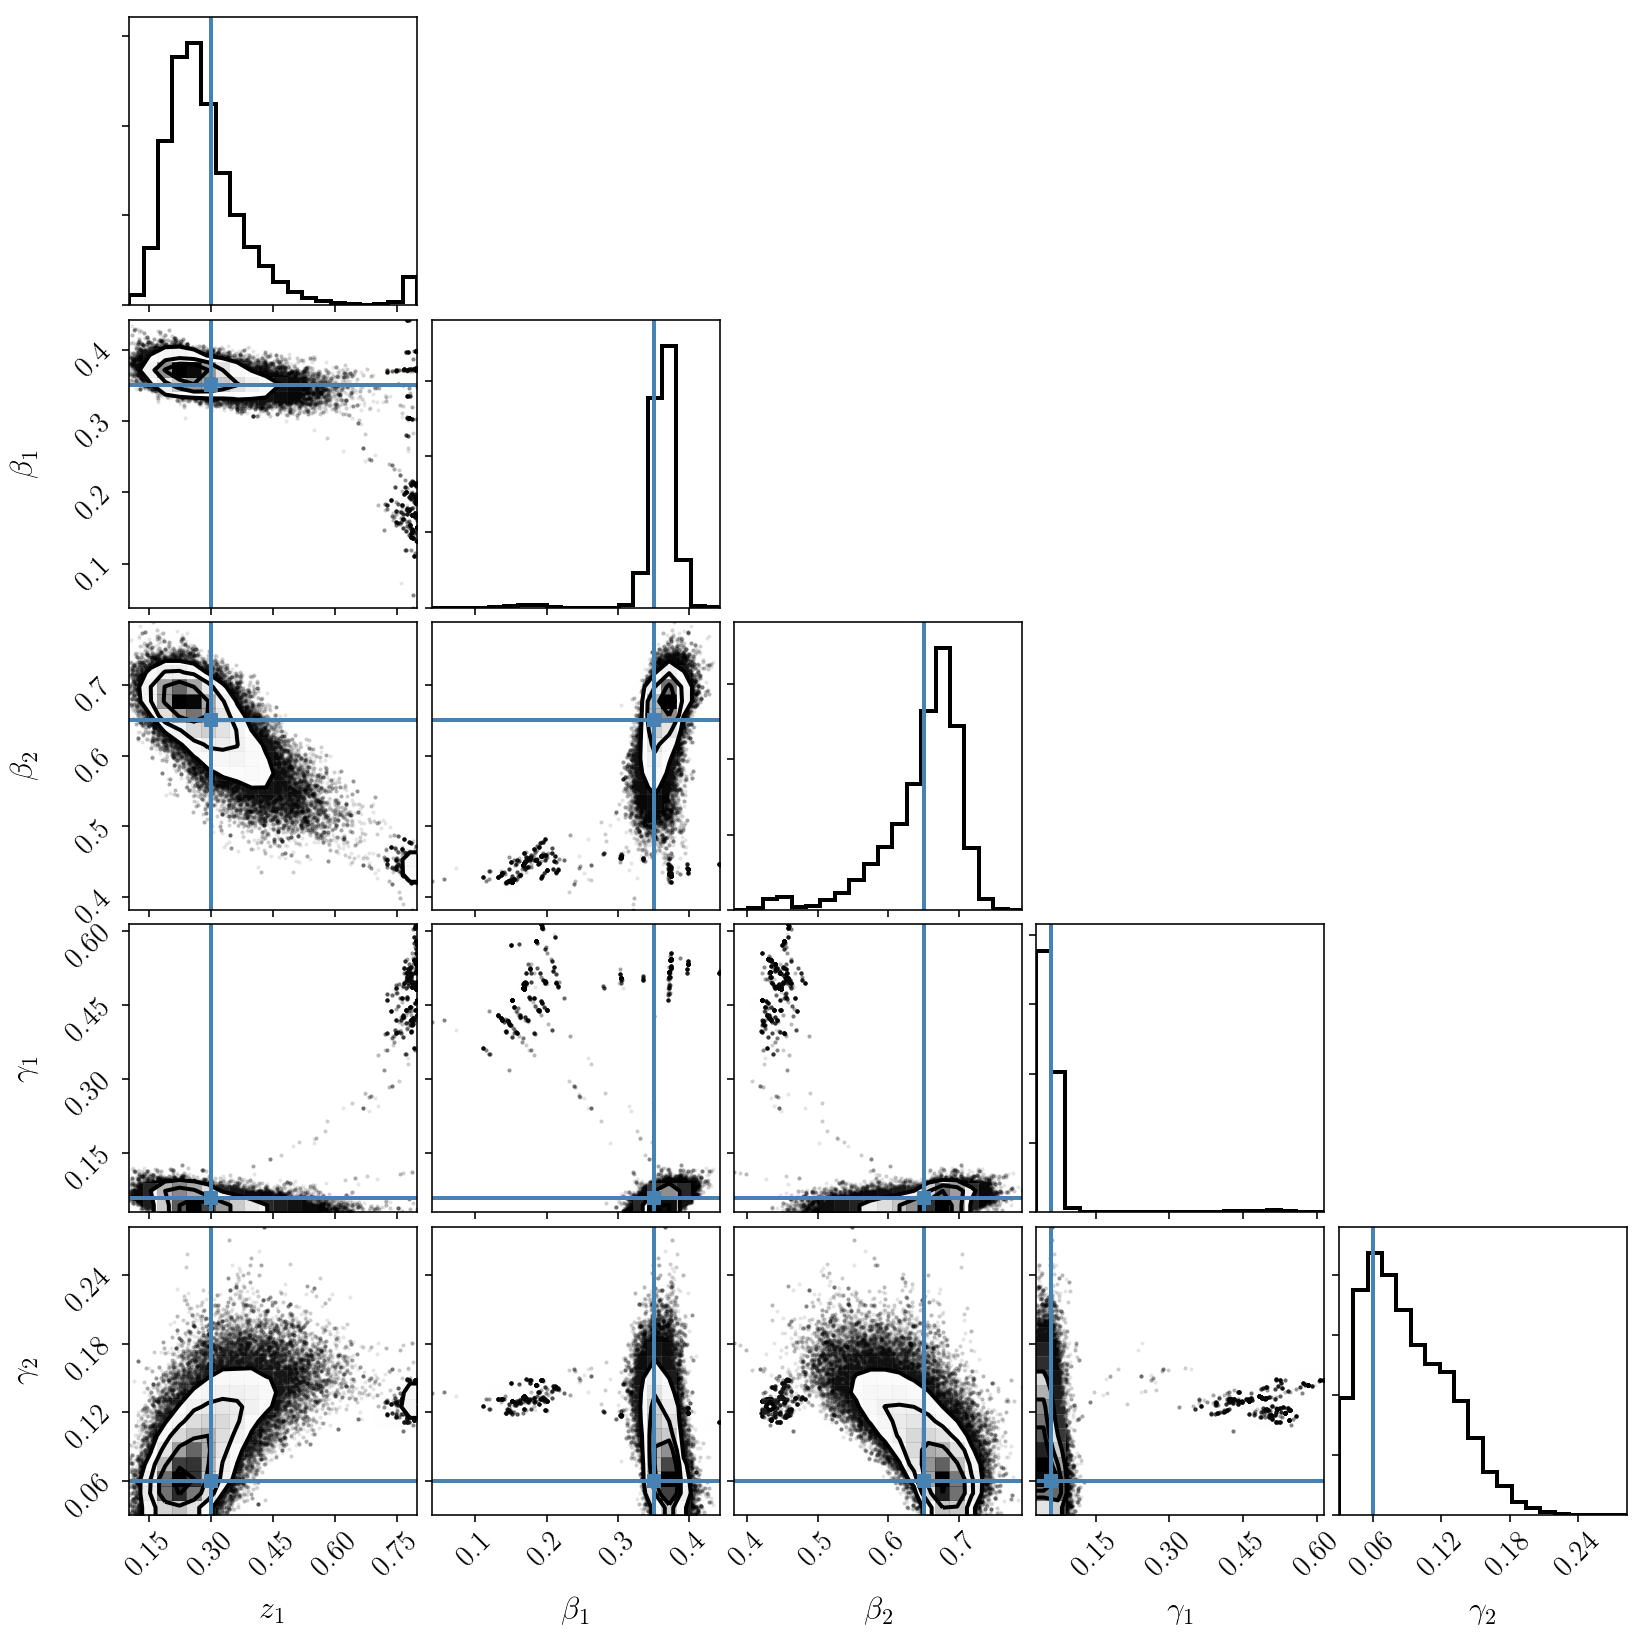

In [9]:
param_names = [r'$z_'+str(i+1)+'$' for i in range(nt-1)] +\
    [r'$\beta_'+str(i+1)+'$' for i in range(nt)] +\
    [r'$\gamma_'+str(i+1)+'$' for i in range(nt)]
_ = corner.corner(sampler.flatchain, truths=params, labels=param_names)

We now see that we have solved those issues and that we obtain a nicely sampled unimodal posterior distribution, with the true values correctly included.

(If you see some strange tail and isolated samples that seem to indicate a secondary mode, please ignore this at the moment. This is real, and will be discussed later.)

A nice visualization of the result is in data space, where we evaluate our model for a few hundred samples of the posterior distribution, and see that they are nicely around the truth.

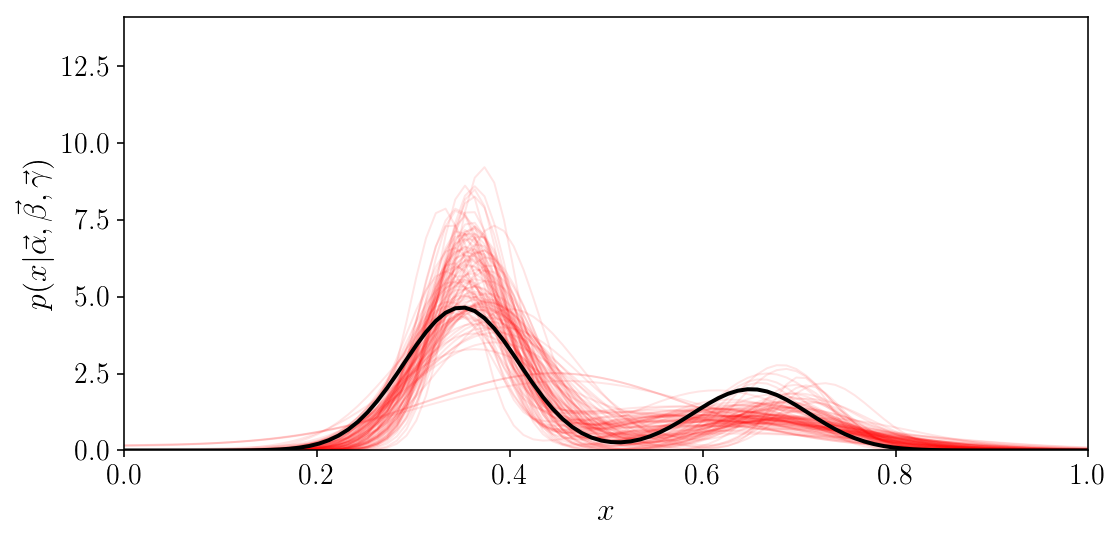

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
for i in np.random.choice(sampler.flatchain.shape[0], 100, replace=False):
    alphas2 = zs_to_alphas(sampler.flatchain[i, 0:nt-1])
    betas2 = sampler.flatchain[i, nt-1:2*nt-1]
    gammas2 = sampler.flatchain[i, 2*nt-1:3*nt-1]
    p_x_grid2 = alphas2[None, :] * np.exp(-0.5*((x_grid[:, None] - betas2[None, :])/gammas2[None, :])**2)/\
    np.sqrt(2*np.pi)/gammas2[None, :]
    p_x_grid2 = np.sum(p_x_grid2, axis=1)
    ax.plot(x_grid, p_x_grid2, color='r', alpha=0.1, lw=1)
ax.plot(x_grid, p_x_grid[:, :].sum(axis=1), c='k')
ax.set_xlim([0, 1])
ax.set_ylim([0, axs[0].get_ylim()[1]*1.7])
ax.set_ylabel(r'$p(x|\vec{\alpha}, \vec{\beta}, \vec{\gamma})$')
ax.set_xlabel(r'$x$')
fig.tight_layout()

## HMC with automatic differentiation

As discussed above, there are few real-world situations where the population and likelihood probabilities are Gaussian and one can integrate over the latent variables analytically. Therefore, we would like to see if we can sample from the full posterior distribution. In other words, we will sample from 

$p(\vec{f},\vec{\beta}, \vec{\gamma}, \{ x_i \} | \{y_i, \sigma_i\})\propto p(\vec{f},\vec{\beta}, \vec{\gamma}) \prod_{i=1}^N  \sum_{b=1}^B f_b \mathcal{N}(x_i|\beta_b,\gamma^2_b)\mathcal{N}(y_i|x_i,\sigma^2_i)$

By histogramming the samples only in the $\vec{f},\vec{\beta}, \vec{\gamma}$ dimensions, we should recover the previous results (from the simplified posterior distribution $p(\vec{f},\vec{\beta}, \vec{\gamma}, \{ x_i \} | \{y_i, \sigma_i\})$) since this is equivalent to numerically integrating out the $x_i$'s.

Since this model has many more parameters ($3B+N-1$ instead of $3B-1$), standard MCMC methods like emcee will struggle. This is before those have a small acceptance rate ($\approx 0.3$). Moreover, due to volume effects, the space to explore is very large, so there is a chance the relevant portions of the full posterior distribution will rarely be explored. This is known as the curve of dimensionality.

A common way to get around this problem is to adopt a more efficient MCMC method: Hamiltonian or Hybrid Monte Carlo. It has high acceptance rate (close to 1), and this method is designed to explore large parameter spaces and deal with nasty degenerate distributions. This is exactly what we need. Note that it cannot deal with multimodal distribution - we will come back to this point later in this tutorial.

One of the peculiarities of HMC is that it requires gradients of the posterior with respect to the parameters of interest. In our case, we could write those analytically. But in real world problems this might be cumbersome and error-prone. Thus, we will use a powerful tool: **automatic differentiation**. This originates from the simple observation that differentiation rules are simple and can be propagated via the chain rule. If one can write the posterior distribution from elementary analytical or numerical operations, then finding the gradients is most likely a very simple algorithmic task that doesn't need to be done by hand. And indeed, there are automatic differentiation packages that will go through a piece of code and infer the analytic form of the gradient from elementary functions. Autograd is one of those, and only require that you write your function (here the posterior distribution) with numpy (or rather, its wrapped version of numpy, as you can see from how we have imported numpy and autograd at the start of this notebook). 

We will now ask autograd to create a function that computed the analytic gradient of our posterior distribution with automatic differentiation! At the moment, we will focus on our simplified posterior distribution and check that the HMC approach works, before moving to the full posterior distribution.

In [11]:
lnprob_hyperonly1_grad = grad(lnprob_hyperonly1)

We can numerically verify that it is indeed the gradient of our function: 

In [12]:
params = np.concatenate([alphas, betas, gammas])

def fun(params):
    return lnprob_hyperonly1(params)
def fun_grad(params):
    return lnprob_hyperonly1_grad(params)

relative_accuracy = 0.00001
test_derivative(params, fun, fun_grad, relative_accuracy)  
# Will complain if the gradient is incorrect

Of course, this gradient works for our original simplified posterior distribution, not the reparametrized one. So it will suffer from the degeneracies and multimodality we've already discussed. We want to avoid that and use our reparametrized posterior.

If you try to apply autograd to the latter, you will get an error message saying that 'numpy.cumprod' is not yet implemented in autograd. This is the limitation of automatic differentiation: sometimes the operations used in a model are not supported. In our case, we can easily get around this problem by performing the change of variables manually (also explained in arxiv:1010.3436). In most cases, one can use automatic differentiation for large chunks of a model, and implement the rest by hand.

Note that autograd also allows us to extract the Hessian of our distribution of interest. We will use that to tune our HMC run and make it blazingly efficient. This is explained in arxiv:1206.1901 and also many other HMC papers.

In [13]:
def sublnprob_hyperonly(params):
    alphas, betas, gammas = params[0:nt], params[nt:2*nt], params[2*nt:3*nt]
    xis = params[3*nt:3*nt+nobj]
    lnlikes = np.log(alphas[None, :]) + lngaussian(yis[:, None], betas[None, :], 
                                      np.sqrt(gammas[None, :]**2. + sigmais[:, None]**2.))
    res = - np.sum(logsumexp(lnlikes, axis=1))
    if ~np.isfinite(res):
        print("Infinite likelihood call with", params)
    return res

def lnprob_hyperonly(params):
    zs, betas, gammas = params[0:nt-1], params[nt-1:2*nt-1], params[2*nt-1:3*nt-1]
    alphas = zs_to_alphas(zs)
    res = sublnprob_hyperonly(np.concatenate([alphas, params[nt-1:]]))
    return res

sublnprob_hyperonly_grad = grad(sublnprob_hyperonly)
sublnprob_hyperonly_hessian = hessian(sublnprob_hyperonly)

def lnprob_hyperonly_grad(params):
    zs, betas, gammas = params[0:nt-1], params[nt-1:2*nt-1], params[2*nt-1:3*nt-1]
    alphas = zs_to_alphas(zs)
    jac = alphaszs_jacobian(alphas, zs)
    subgrads = sublnprob_hyperonly_grad(np.concatenate([alphas, params[nt-1:]]))
    grads = 1*subgrads[1:]
    grads[0:nt-1] = np.dot(jac, subgrads[0:nt])
    if np.any(~np.isfinite(grads)):
        print("Infinite likelihood gradient call with", params)
    return grads


def lnprob_hyperonly_hessian(params):
    zs, betas, gammas = params[0:nt-1], params[nt-1:2*nt-1], params[2*nt-1:3*nt-1]
    alphas = zs_to_alphas(zs)
    jac = alphaszs_jacobian(alphas, zs)
    subhess = sublnprob_hyperonly_hessian(np.concatenate([alphas, params[nt-1:]]))
    subhessdiag = np.diag(subhess)
    hess = 1*subhessdiag[1:]
    hess[0:nt-1] = np.diag(np.dot(np.dot(jac, subhess[0:nt, 0:nt]), jac.T))
    if np.any(~np.isfinite(hess)):
        print("Infinite likelihood hessian call with", params)
    return hess


params = np.concatenate([zs, betas, gammas])
#print(lnprob_hyperonly(params), lnprob_hyperonly_grad(params), lnprob_hyperonly_hessian(params))

def fun(params):
    return lnprob_hyperonly(params)
def fun_grad(params):
    return lnprob_hyperonly_grad(params)

relative_accuracy = 0.0001
test_derivative(params, fun, fun_grad, relative_accuracy, superverbose=False)

def fun_hess(params):
    return lnprob_hyperonly_hessian(params)

relative_accuracy = 0.001
test_derivative(params, fun, fun_hess, relative_accuracy, superverbose=False, n=2)

## Third MCMC run: HMC on the simplified posterior

The code below is an implementation of the classic HMC algorithm with bounds and a mass matrix. It is not parallelized, so we expect it will be slower than emcee. However, by using analytic derivatives and Hessian, we should hope that it performs well and samples the target distribution very well. We will use random step sizes and lengths, too. Those technical choices are fairly common and discussed in Neal (2006). We will also update the Hessian every 500 iterations. This tends to work better (than finding the optimum and computing the Hessian once) for nasty distributions.

Our sampler will throw a warning every time it rejects a sampler (which is possible due to numerical approximations involved in the HMC algorithm). But this will be very rare, so our acceptance rate will be very close to one. 

In [14]:
# This is the function that performs one HMC sample, 
# with num_steps steps of size step_size relative to the gradient.
# x0 is the initial point, lnprob the posterior distribution, lnprobgrad is gradients.
def hmc_sampler(x0, lnprob, lnprobgrad, step_size,
                num_steps, inv_mass_matrix_diag=None, bounds=None, kwargs={}):
    if bounds is None:
        bounds = np.zeros((x0.size, 2))
        bounds[:, 0] = 0.001
        bounds[:, 1] = 0.999
    if inv_mass_matrix_diag is None: 
        inv_mass_matrix_diag = np.repeat(1, x0.size)
        inv_mass_matrix_diag_sqrt = np.repeat(1, x0.size)
    else:
        assert inv_mass_matrix_diag.size == x0.size
        inv_mass_matrix_diag_sqrt = inv_mass_matrix_diag**0.5
    v0 = np.random.randn(x0.size) / inv_mass_matrix_diag_sqrt
    v = v0 - 0.5 * step_size * lnprobgrad(x0, **kwargs)
    x = x0 + step_size * v * inv_mass_matrix_diag
    ind_upper = x > bounds[:, 1]
    x[ind_upper] = 2*bounds[ind_upper, 1] - x[ind_upper]
    v[ind_upper] = - v[ind_upper]
    ind_lower = x < bounds[:, 0]
    x[ind_lower] = 2*bounds[ind_lower, 0] - x[ind_lower]
    v[ind_lower] = - v[ind_lower]
    ind_upper = x > bounds[:, 1]
    ind_lower = x < bounds[:, 0]
    ind_bad = np.logical_or(ind_lower, ind_upper)
    if ind_bad.sum() > 0:
        print('Error: could not confine samples within bounds!')
        print('Number of problematic parameters:', ind_bad.sum(), 'out of', ind_bad.size)
        return x0
                
    for i in range(num_steps):
        v = v - step_size * lnprobgrad(x, **kwargs)
        x = x + step_size * v * inv_mass_matrix_diag
        ind_upper = x > bounds[:, 1]
        x[ind_upper] = 2*bounds[ind_upper, 1] - x[ind_upper]
        v[ind_upper] = - v[ind_upper]
        ind_lower = x < bounds[:, 0]
        x[ind_lower] = 2*bounds[ind_lower, 0] - x[ind_lower]
        v[ind_lower] = - v[ind_lower]
        ind_upper = x > bounds[:, 1]
        ind_lower = x < bounds[:, 0]
        ind_bad = np.logical_or(ind_lower, ind_upper)
        if ind_bad.sum() > 0:
            print('Error: could not confine samples within bounds!')
            print('Number of problematic parameters:', ind_bad.sum(), 'out of', ind_bad.size)
            return x0

    v = v - 0.5 * step_size * lnprobgrad(x, **kwargs)
    orig = lnprob(x0, **kwargs)
    current = lnprob(x, **kwargs)
    if inv_mass_matrix_diag is None:
        orig += 0.5 * np.dot(v0.T, v0)
        current += 0.5 * np.dot(v.T, v)
    else:
        orig += 0.5 * np.sum(inv_mass_matrix_diag * v0**2.)
        current += 0.5 * np.sum(inv_mass_matrix_diag * v**2.)
        
    p_accept = min(1.0, np.exp(orig - current))
    if(np.any(~np.isfinite(x))):
        print('Error: some parameters are infinite!', np.sum(~np.isfinite(x)), 'out of', x.size)
        print('HMC steps and stepsize:', num_steps, step_size)
        return x0
    if p_accept > np.random.uniform():
        return x
    else:
        if p_accept < 0.01:
            print('Sample rejected due to small acceptance probability (', p_accept, ')')
            print('HMC steps and stepsize:', num_steps, step_size)
            #stop
        return x0

In [15]:
num_samples, burnin = 20000, 2000

params = np.concatenate([zs, betas, gammas])
bounds = np.zeros((params.size, 2))
bounds[:, 0] = 0.03
bounds[:, 1] = 0.97
param_samples_hyperonly = np.zeros((num_samples, params.size))
param_samples_hyperonly[0, :] = params 

hess = np.abs(lnprob_hyperonly_hessian(params))
for i in range(1, num_samples):
    step_size = np.random.uniform(1e-3, 1e-1)
    num_steps = np.random.randint(2, 10)
    if i % 500 == 0:
        print(i, end=" ")
        newparams = np.mean(param_samples_hyperonly[0:i-1, :], axis=0)
        hess = np.abs(lnprob_hyperonly_hessian(newparams))
    param_samples_hyperonly[i, :] =\
        hmc_sampler(param_samples_hyperonly[i-1, :],
                    lnprob_hyperonly, lnprob_hyperonly_grad,
                    step_size, num_steps,
                    bounds=bounds, inv_mass_matrix_diag=1./hess)
param_samples_hyperonly = param_samples_hyperonly[burnin:, :]

500 1000 1500 2000 2500 3000 3500 4000 4500 5000 5500 6000 6500 7000 7500 8000 8500 9000 9500 10000 10500 11000 11500 12000 12500 13000 13500 14000 14500 15000 15500 16000 16500 17000 17500 18000 18500 19000 19500 

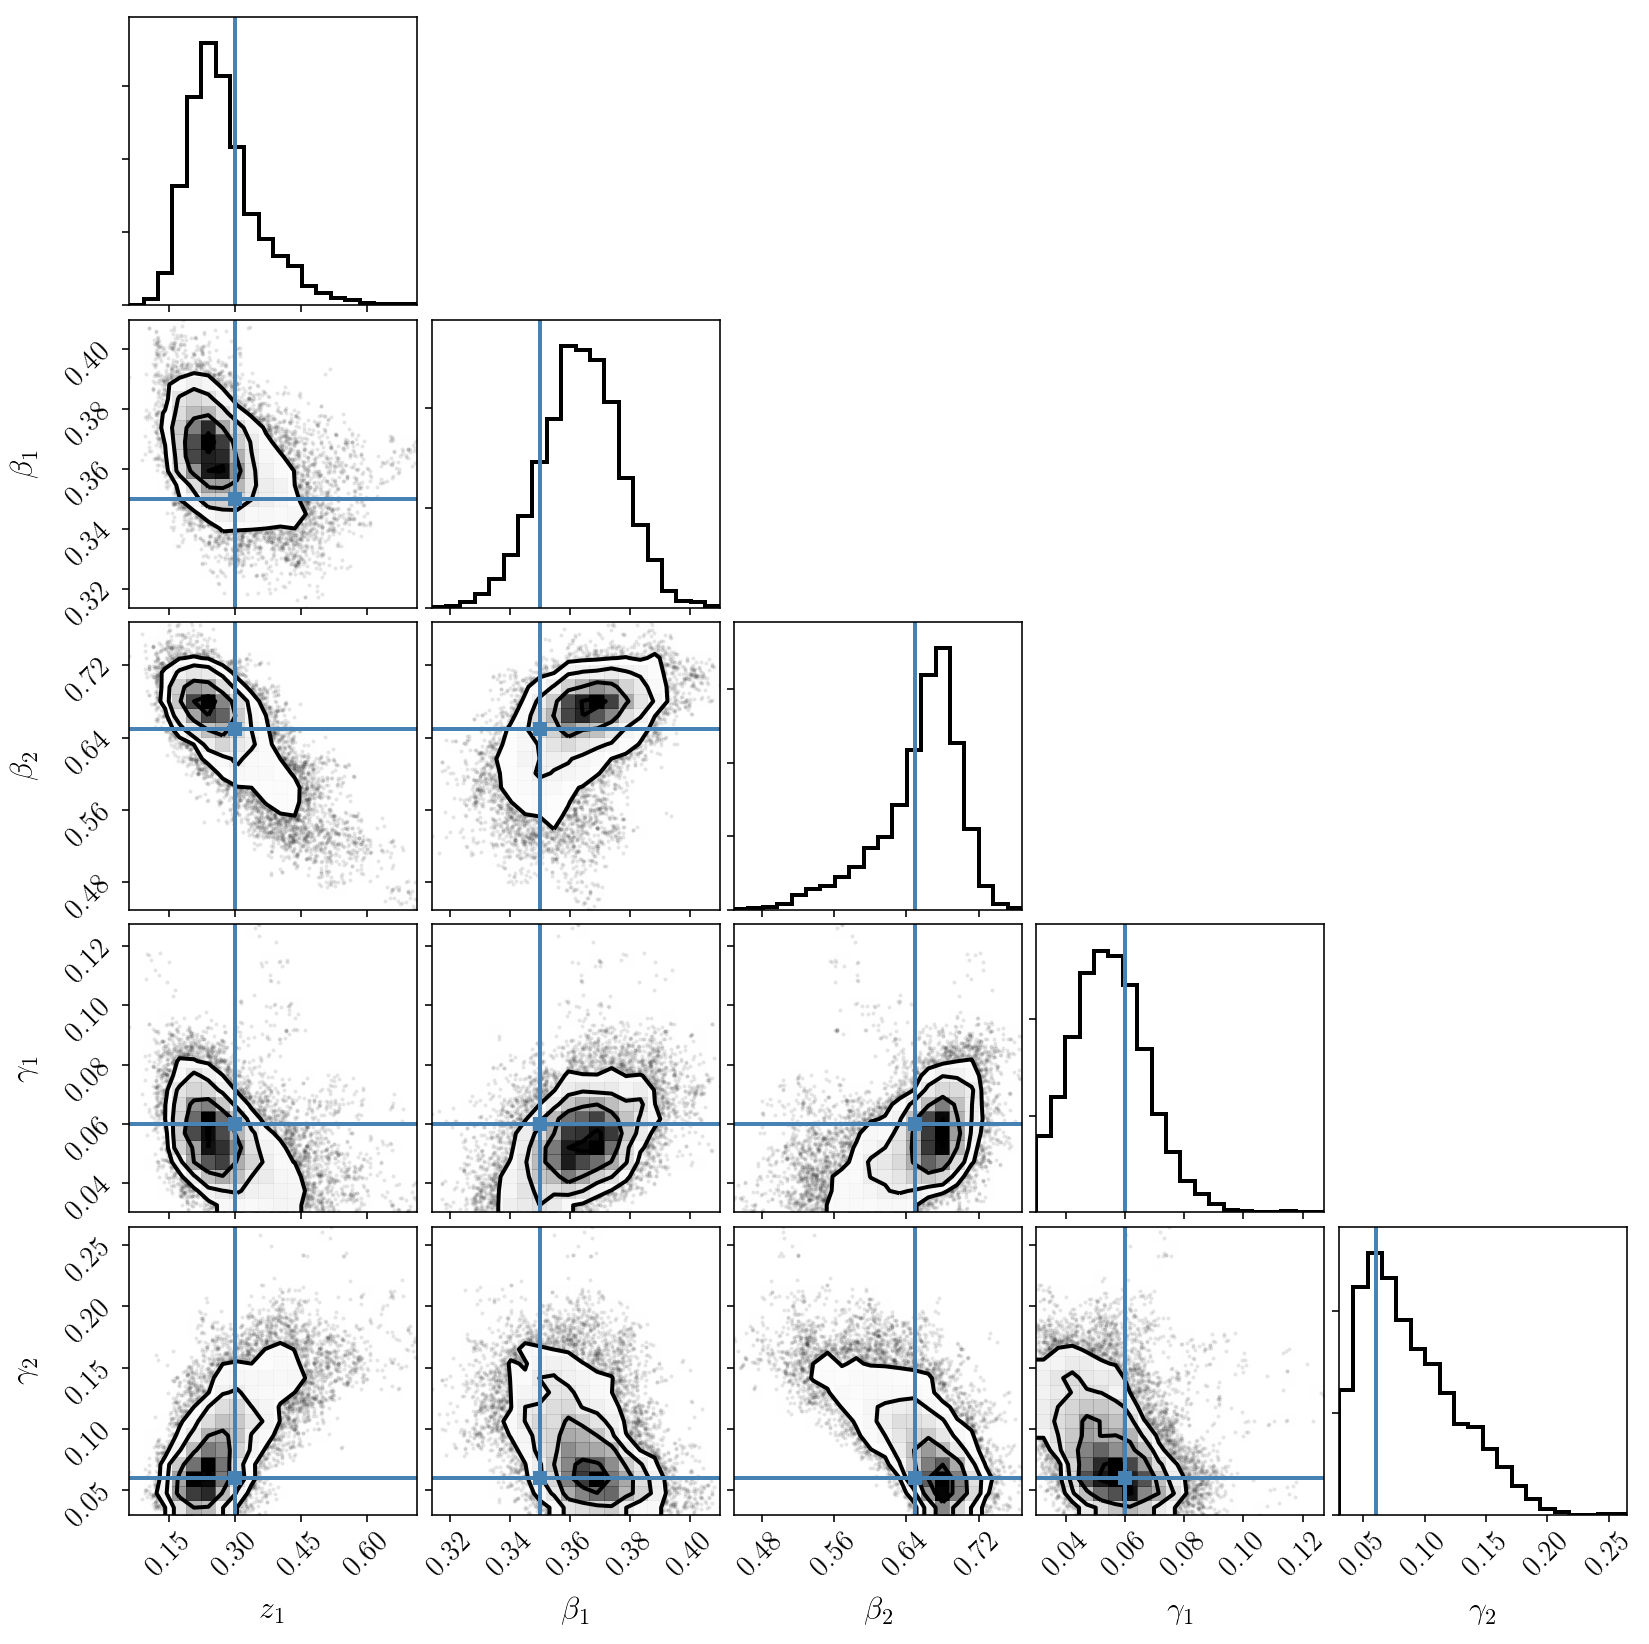

In [16]:
_ = corner.corner(param_samples_hyperonly, truths=params, labels=param_names)

The marginalized posterior distribution for pairs of parameters looks good. Let's look at the marginalized posterior for the individual parameters and compare with the results we obtained with emcee.

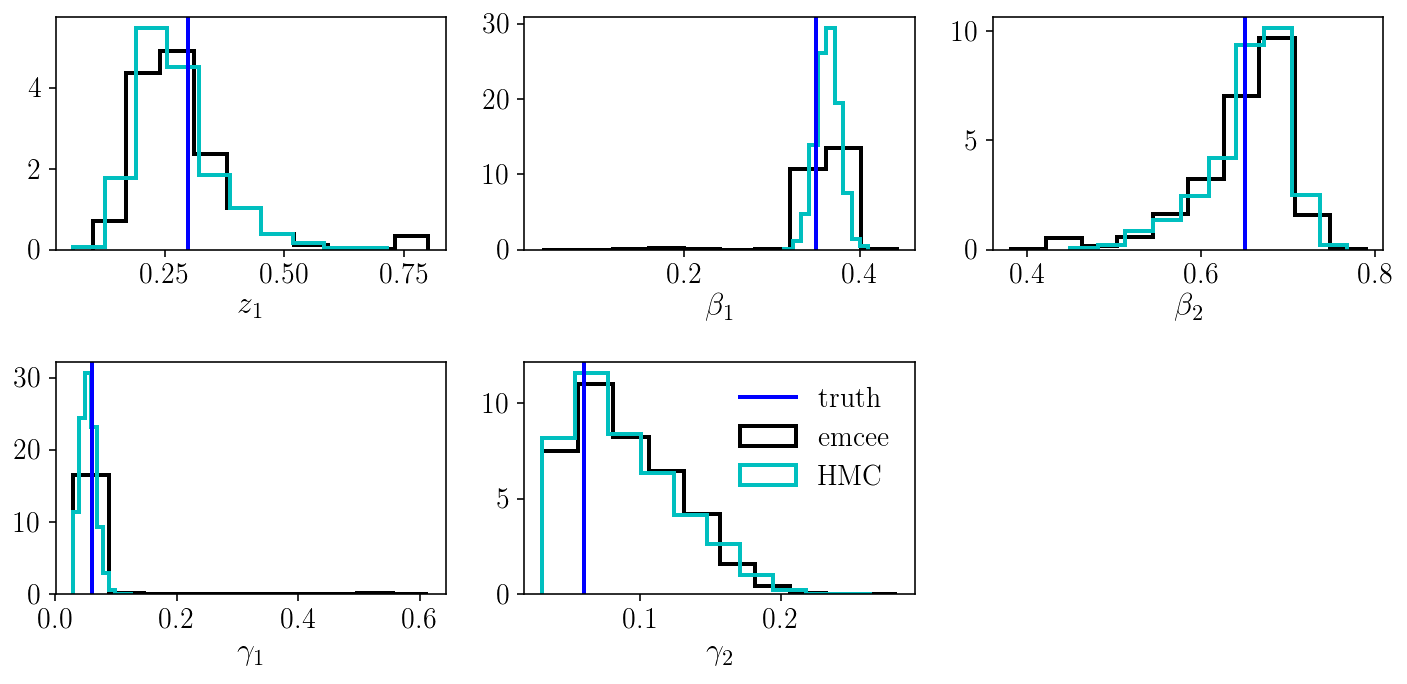

In [17]:
fig, axs = plt.subplots(2, 3, figsize=(10, 5))
axs = axs.ravel()
for i in range(5):
    axs[i].hist(sampler.flatchain[:, i], histtype='step', normed=True, label='emcee')
    axs[i].hist(param_samples_hyperonly[:, i], histtype='step', normed=True, label='HMC')
    axs[i].axvline(params[i], c='b', label='truth')
    axs[i].set_xlabel(param_names[i])
axs[-2].legend(frameon=False)
plt.delaxes(axs[-1])
fig.tight_layout()

As we can see, the HMC run was successful, which is good! However, it is slower than emcee. This is because, despite using gradient information to obtain a higher acceptance rate (close to 1, as opposed to 0.3), our HMC sampler is not parallelized. And emcee is generally blazingly fast. 

However, we will now sample the full posterior distribution, which emcee cannot deal with since it has way too many parameters.

## Sampling the full posterior distribution with HMC

We will now sample 

$p(\vec{f},\vec{\beta}, \vec{\gamma}, \{ x_i \} | \{y_i, \sigma_i\})\propto p(\vec{f},\vec{\beta}, \vec{\gamma}) \prod_{i=1}^N  \sum_{b=1}^B f_b \mathcal{N}(x_i|\beta_b,\gamma^2_b)\mathcal{N}(y_i|x_i,\sigma^2_i)$

use the same technical tricks as before.

In [18]:
def sublnprob_withxis(params):
    alphas, betas, gammas = params[0:nt], params[nt:2*nt], params[2*nt:3*nt]
    xis = params[3*nt:3*nt+nobj]
    lnlikes = np.log(alphas[None, :]) + lngaussian(xis[:, None], betas[None, :], gammas[None, :]) + \
        lngaussian(yis[:, None], xis[:, None], sigmais[:, None])
    res = - np.sum(logsumexp(lnlikes, axis=1))
    if ~np.isfinite(res):
        print("Infinite likelihood call with", params)
    return res

def lnprob_withxis(params):
    zs, betas, gammas = params[0:nt-1], params[nt-1:2*nt-1], params[2*nt-1:3*nt-1]
    alphas = zs_to_alphas(zs)
    res = sublnprob_withxis(np.concatenate([alphas, params[nt-1:]]))
    return res

sublnprob_withxis_grad = grad(sublnprob_withxis)
sublnprob_withxis_hessian = hessian(sublnprob_withxis)

def lnprob_withxis_grad(params):
    zs, betas, gammas = params[0:nt-1], params[nt-1:2*nt-1], params[2*nt-1:3*nt-1]
    alphas = zs_to_alphas(zs)
    jac = alphaszs_jacobian(alphas, zs)
    subgrads = sublnprob_withxis_grad(np.concatenate([alphas, params[nt-1:]]))
    grads = 1*subgrads[1:]
    grads[0:nt-1] = np.dot(jac, subgrads[0:nt])
    if np.any(~np.isfinite(grads)):
        print("Infinite likelihood gradient call with", params)
    return grads


def lnprob_withxis_hessian(params):
    zs, betas, gammas = params[0:nt-1], params[nt-1:2*nt-1], params[2*nt-1:3*nt-1]
    alphas = zs_to_alphas(zs)
    jac = alphaszs_jacobian(alphas, zs)
    subhess = sublnprob_withxis_hessian(np.concatenate([alphas, params[nt-1:]]))
    subhessdiag = np.diag(subhess)
    hess = 1*subhessdiag[1:]
    hess[0:nt-1] = np.diag(np.dot(np.dot(jac, subhess[0:nt, 0:nt]), jac.T))
    if np.any(~np.isfinite(hess)):
        print("Infinite likelihood hessian call with", params)
    return hess

params = np.concatenate([zs, betas, gammas, xis])
#print(lnprob_withxis(params), lnprob_withxis_grad(params), lnprob_withxis_hessian(params))

def fun(params):
    return lnprob_withxis(params)
def fun_grad(params):
    return lnprob_withxis_grad(params)

# Numerically test the gradient
relative_accuracy = 0.001
test_derivative(params, fun, fun_grad, relative_accuracy, superverbose=False)

def fun_hess(params):
    return lnprob_withxis_hessian(params)

# Numerically test the hessian
relative_accuracy = 0.001
test_derivative(params, fun, fun_hess, relative_accuracy, superverbose=False, n=2)

In [19]:
num_samples, burnin = 20000, 2000

params = np.concatenate([zs, betas, gammas, xis])
bounds = np.zeros((params.size, 2))
bounds[:, 0] = 0.03
bounds[:, 1] = 0.97
param_samples_withxis = np.zeros((num_samples, params.size))
param_samples_withxis[0, :] = params 

hess = np.abs(lnprob_withxis_hessian(params))
for i in range(1, num_samples):
    step_size = 10.**np.random.uniform(-3, -1)
    num_steps = np.random.randint(5, 20)
    if i % 500 == 0:
        print(i, end=" ")
        newparams = np.mean(param_samples_withxis[0:i-1, :], axis=0)
        hess = np.abs(lnprob_withxis_hessian(newparams))
    param_samples_withxis[i, :] =\
        hmc_sampler(param_samples_withxis[i-1, :],
                    lnprob_withxis, lnprob_withxis_grad,
                    step_size, num_steps,
                    bounds=bounds, inv_mass_matrix_diag=1./hess)
param_samples_withxis = param_samples_withxis[burnin:, :]

500 1000 1500 2000 2500 3000 3500 4000 4500 5000 5500 6000 6500 7000 7500 8000 8500 9000 9500 10000 10500 11000 11500 12000 12500 13000 13500 14000 14500 15000 Sample rejected due to small acceptance probability ( 0.00518638470741 )
HMC steps and stepsize: 15 0.08678448230612879
15500 16000 16500 17000 17500 18000 18500 19000 Sample rejected due to small acceptance probability ( 1.05272805661e-05 )
HMC steps and stepsize: 18 0.09333857555177628
Sample rejected due to small acceptance probability ( 1.66585526655e-87 )
HMC steps and stepsize: 9 0.09616979812853865
Sample rejected due to small acceptance probability ( 8.11390803155e-41 )
HMC steps and stepsize: 17 0.09303497008980544
Sample rejected due to small acceptance probability ( 5.97264852246e-05 )
HMC steps and stepsize: 17 0.06316786971330617
Sample rejected due to small acceptance probability ( 9.47516141814e-05 )
HMC steps and stepsize: 12 0.0883834576635165
Sample rejected due to small acceptance probability ( 0.0017180568446

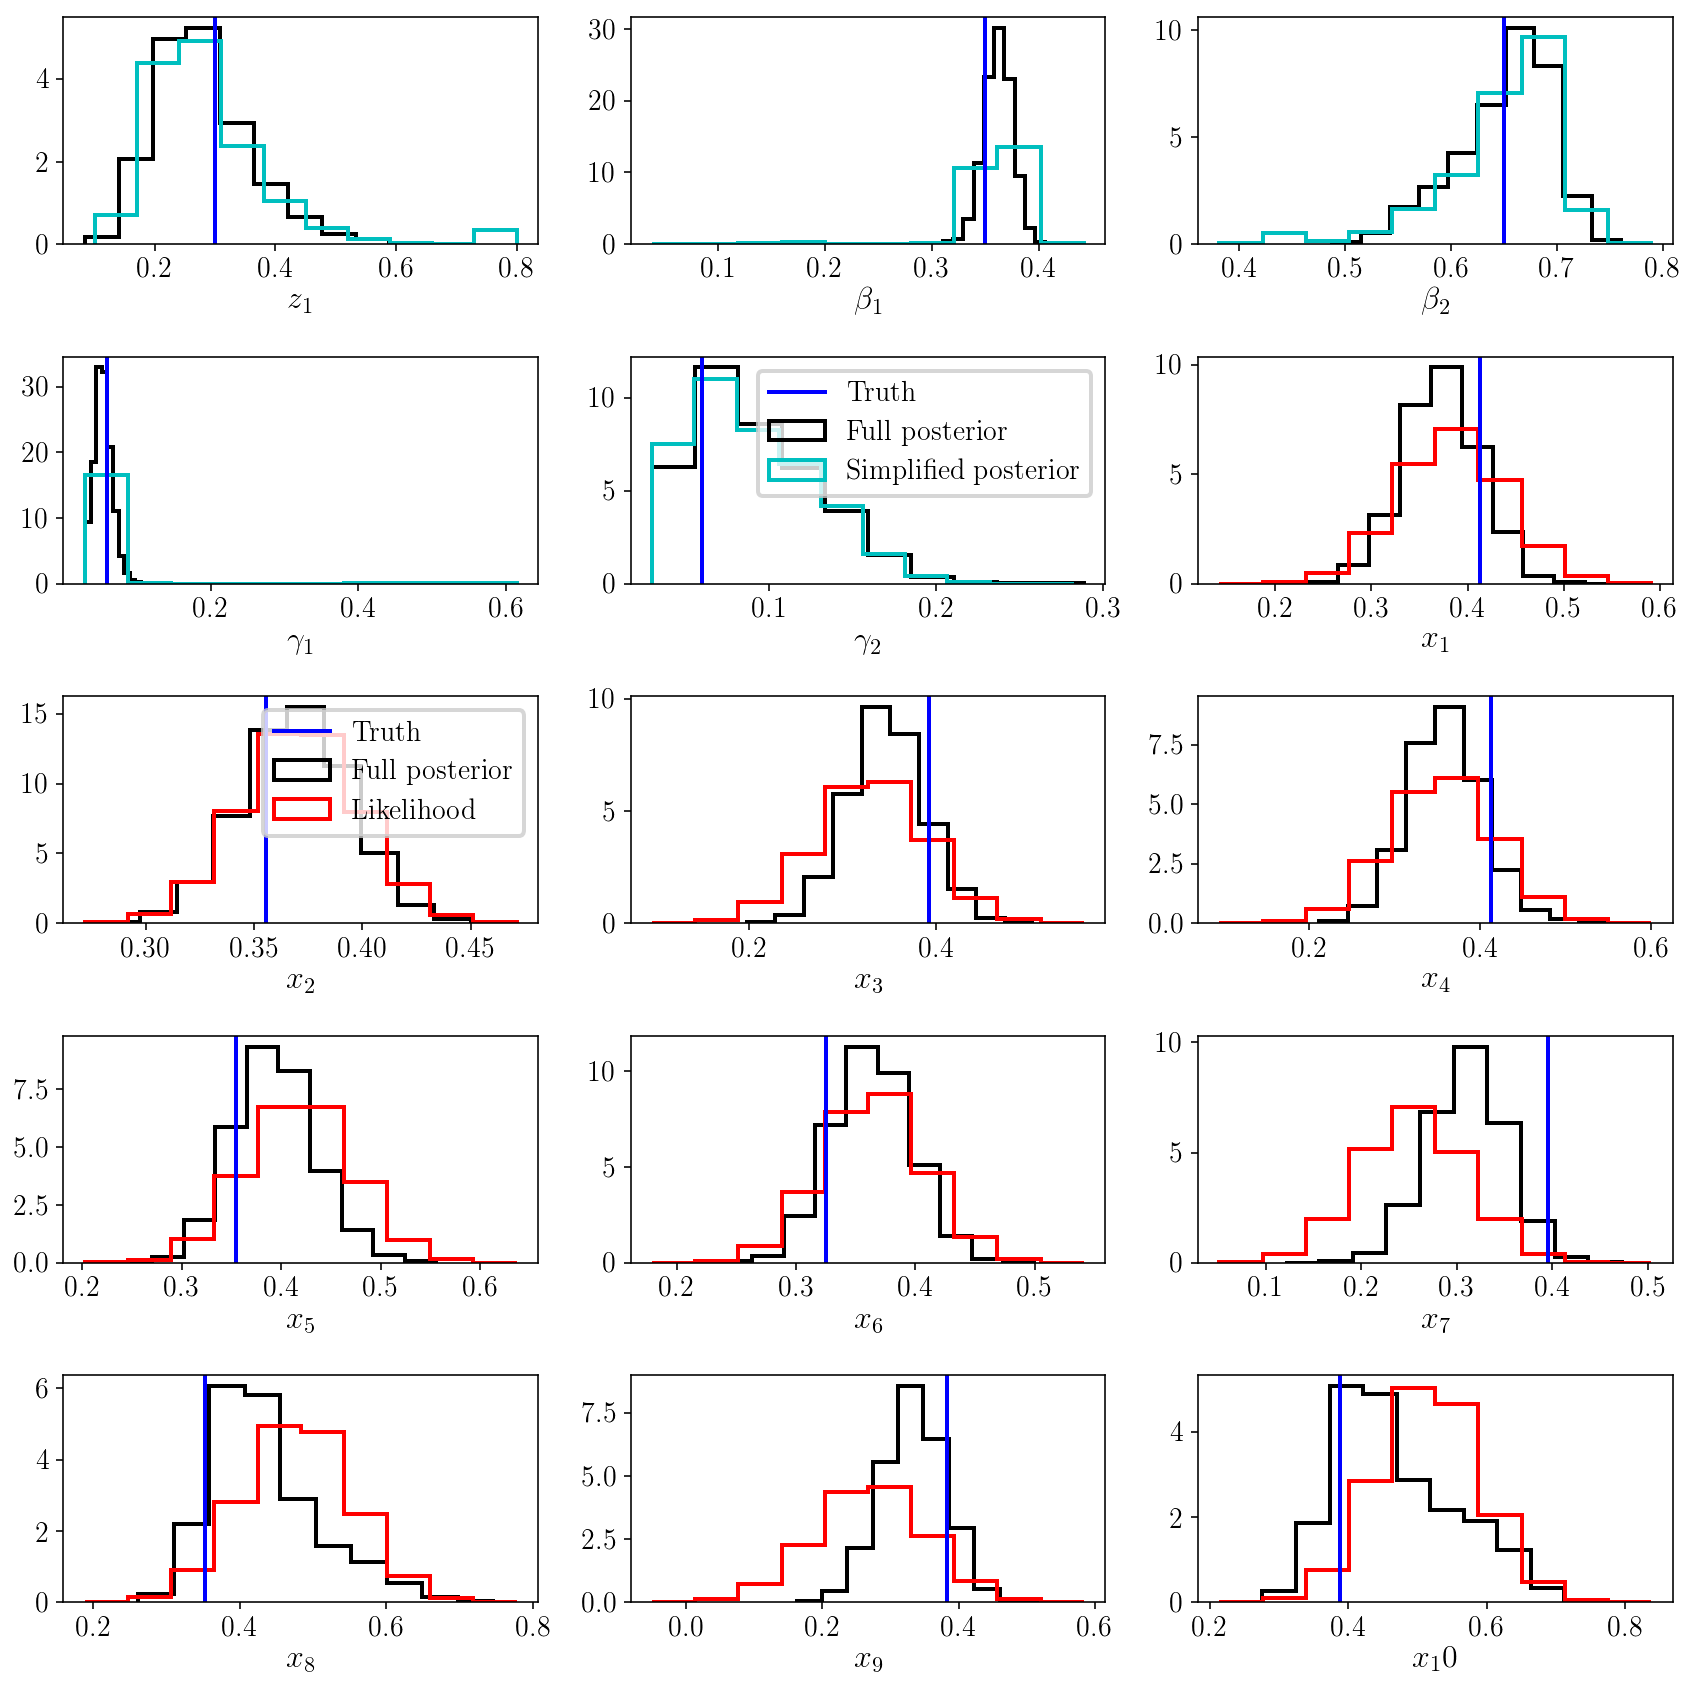

In [24]:
param_names = [r'$z_'+str(i+1)+'$' for i in range(nt-1)] +\
    [r'$\beta_'+str(i+1)+'$' for i in range(nt)] +\
    [r'$\gamma_'+str(i+1)+'$' for i in range(nt)]+\
    [r'$x_'+str(i+1)+'$' for i in range(nobj)]
fig, axs = plt.subplots(5, 3, figsize=(12, 12))
axs = axs.ravel()
for i in range(axs.size):
    axs[i].set_xlabel(param_names[i])
    axs[i].hist(param_samples_withxis[:, i], histtype='step', normed=True, label='Full posterior')
    if i < 5:
        axs[i].hist(sampler.flatchain[:, i], histtype='step', normed=True, label='Simplified posterior')    
    axs[i].axvline(params[i], c='b', label='Truth')
    if i >= 5:
        likedraws = yis[i-5] + np.random.randn(param_samples_withxis[:, i].size) * sigmais[i-5]
        axs[i].hist(likedraws, histtype='step', normed=True, color='red', label='Likelihood')
    if i == 6 or i == 4:
        axs[i].legend(loc='upper right', frameon=True)
fig.tight_layout()

The marginalized posterior distribution looks good. For the population parameters $\vec{z}, \vec{\beta}, \vec{\gamma}$, it matches what we obtained with the simplified posterior distribution. This is remarkable because we have added a ton of parameters to the model, and explored a much bigger parameter volume. Thanks to HMC, this exploration was efficient, and we were able to numerically marginalize over all the latent variables $x_i$'s and recover the results from the analytic solution, the simplified posterior distribution.

The other panels in the figure above show a comparison of the posterior distribution on each $x_i$ versus the likelihood function $p(y_i | x_i)$. This is a typical illustration of Bayesian shrinkage: by fitting a model to the population of objects, we in turn improve the individual estimates. It doesn't matter that those parameters are latent - they are connected via a hierarchical probabilistic model, so the information gained in one part of the model might actually affect the rest of the model. This is a theme that we have explored and will continue to explore in other tutorials.

## Final comments: number of components and multimodality

We have not discussed a number of potential issues that might arise, including what happens if the data are very noisy and/or the components significantly overlap. Those are common with mixture models.

Indeed, those can create new degeneracies in the posterior distribution, since components can more easily be interchanged if they overlap or in the presence of significant noise. One can still find a prior that alleviates those degeneracies, but this might not be sufficient. In that case, an HMC sampler that is carefully tuned should still work. But if the distribution is really multimodal, then one could adopt a "tempered" HMC sampler. For example, the approach of https://arxiv.org/abs/1704.03338 is interesting.

Another related question is how to find a suitable prior to alleviate labelling degeneracies in $>1$ dimensions. This is possible, but may require some careful thinking. Again, the key is to order the components in a quasi-unique fashion. 

But the most critical question we have not  mentioned so far is the choice of number of components. In most real-world problems, one does not know how many components to use. This is a vast, deep question which is addressed in countless papers, many of them beyond the scope of this tutorial. The classical approach boils down to doing multiple runs with different number of components, and performing model selection (in a Bayesian fashion) or cross-validation (in a frequentist fashion) to select the best number of components. Indeed, the denominator of our full posterior distribution (neglected previously) is the evidence

$E = p( \{y_i, \sigma_i\} = \int p(\vec{f},\vec{\beta}, \vec{\gamma}, \{ x_i \} | \{y_i, \sigma_i\}) \mathrm{d} \vec{f} \mathrm{d}\vec{\beta} \mathrm{d} \vec{\gamma} \mathrm{d} \{ x_i \}$

In other words, one way or another, a huge multidimensional integral is needed. Calculating evidences accurately is a research topic on its own. One can run a very long MCMC chain and perform this integral numerically. Or adopt a more adequate sampler that explicitly targets the evidence (e.g., via nested sampling). Those options are good. For two runs with two different numbers of components $B_1$ and $B_2$, the evidence ratio (also called Bayes factor) will allow one to perform model selection and pick the preferred number of components. Even better, one could simply consider both models simultaneously, and weight the samples in each model by their respective evidences.

Note that with mixture models, we are in a very particular situation: by fixing one or multiple $z_i$ or $f_i$ to zero or one, the number of components has effectively changed. We say that the models are **nested**. Nested models are very convenient and are worth learning about. Many physical models are nested, and this hugely simplifies model comparison, via the Savage Dickey density ratio, for example.

Equivalently, one could adopt a trans-dimensional approach and explore the space of models with a variable number of components. It is in fact equivalent to multiple-run solution we just discussed. Either way, there are various pieces of technology to achieve that, such as nested sampling or trans-dimensional MCMC (which explicitely adds and removes parameters), which we will not discuss here. 

In our case, we will simply relax our $[0.03, 0.97]$ priors, which we previously use to avoid the multimodal solution. By adopting $[0, 1]$ priors on the amplitude coefficients, we could actually automatically consider a variable number of component. In other words, we would be doing trans-dimensional sampling. There is just one problem: standard sampling techniques will not be able to deal with that, because the target posterior distribution of interest is now multimodal. We would need a better sampling scheme, for example a tempered HMC.

This was initially part of this tutorial but was removed since it introduces quite a lot of extra technical discussion.

In [21]:
nt2 = 4

def sublnprob_hyperonly(params):
    alphas, betas, gammas = params[0:nt2], params[nt2:2*nt2], params[2*nt2:3*nt2]
    lnlikes = np.log(alphas[None, :]) + lngaussian(yis[:, None], betas[None, :], 
                                      np.sqrt(gammas[None, :]**2. + sigmais[:, None]**2.))
    return - np.sum(logsumexp(lnlikes, axis=1))

def lnprob_hyperonly(params):
    zs, betas, gammas = params[0:nt2-1], params[nt2-1:2*nt2-1], params[2*nt2-1:3*nt2-1]
    return sublnprob_hyperonly(np.concatenate([zs_to_alphas(zs), params[nt2-1:]]))

sublnprob_hyperonly_grad = grad(sublnprob_hyperonly)

def lnprob_hyperonly_grad(params):
    zs, betas, gammas = params[0:nt2-1], params[nt2-1:2*nt2-1], params[2*nt2-1:3*nt2-1]
    alphas = zs_to_alphas(zs)
    jac = alphaszs_jacobian(alphas, zs)
    subgrads = sublnprob_hyperonly_grad(np.concatenate([alphas, params[nt2-1:]]))
    grads = 1*subgrads[1:]
    grads[0:nt2-1] = np.dot(jac, subgrads[0:nt2])
    return grads

In [22]:
def lnprob_hyperonly(params):
    zs, betas, gammas = params[0:nt-1], params[nt-1:2*nt-1], params[2*nt-1:3*nt-1]
    alphas = zs_to_alphas(zs)
    for i in range(nt-1):
        if betas[i] >= betas[i+1]:
            return -np.inf
    res = sublnprob_hyperonly(np.concatenate([alphas, params[nt-1:]]))
    return res

In [23]:
numPoints = 10

def prob(params):
    zs, betas, gammas = params[0:nt-1], params[nt-1:2*nt-1], params[2*nt-1:3*nt-1]
    alphas = zs_to_alphas(zs)
    for i in range(nt-1):
        if betas[i] >= betas[i+1]:
            return 0.
    return -lnprob_hyperonly(np.concatenate((alphas, params[nt-1:])))

lines = [np.linspace(0.0, 1.0, numPoints) for i in range(3*nt-1)]
XXX = np.meshgrid(*lines)
XXXflat = np.vstack([X.ravel() for X in XXX]).T
    
print("Number of evaluations: ", XXXflat.shape[0])
probgrid = np.zeros((XXXflat.shape[0], ))
for i in range(XXXflat.shape[0]):
    v = np.exp(prob(XXXflat[i, :]))
    if np.isfinite(v):
        probgrid[i] = v
dh = 1./(numPoints - 1)
probgridint = 1*probgrid.reshape(XXX[0].shape)
for i in range(XXXflat.shape[1]):
    probgridint = np.trapz(probgridint, x=lines[i], axis=0)
del probgrid
evidence = 1*probgridint# np.sum(probgrid) * ((dh/2.)**XXXflat.shape[1])
print(evidence, probgridint)

Number of evaluations:  100000


/Users/bl/anaconda/lib/python3.5/site-packages/autograd/core.py:69: RuntimeWarning: divide by zero encountered in log
  result_value = self.fun(*argvals, **kwargs)


ValueError: operands could not be broadcast together with shapes (100,3) (100,0) 

In [ ]:
evidence2 = np.exp(sampler.flatlnprobability).sum() / nobj**XXXflat.shape[1]
evidence3 = np.exp(np.max(sampler.flatlnprobability)) / (np.pi*2)**((3*nt-1)/2) / np.sqrt(np.linalg.det(onp.cov(sampler.flatchain.T)))
print(evidence, evidence2, evidence3)
print(np.log(evidence), np.log(evidence2), np.log(evidence3))

In [ ]:
from scipy.special import erf

def cumgauss(x):
    return (1. + erf(x/np.sqrt(2.))) / 2.

def lntruncnorm(x, a, b, mu, sc):
    return - np.log(gaussian(x, mu, sc) / (cumgauss((b-mu)/sc) - cumgauss((a-mu)/sc)))

def psi(params):
    return - np.sum(lntruncnorm(params, 0., 1., 0.5, 1))

psi_grad = grad(psi)

logxi = np.log(evidence) + 17
print(logxi)

def lnprob_tempered(params):
    beta = params[0]
    return (1 - beta) * psi(params[1:]) + beta * (lnprob_hyperonly(params[1:]) + logxi)

def lnprob_tempered_grad(params):
    beta = params[0]
    grads = 0*params
    grads[0] = lnprob_hyperonly(params[1:]) + logxi - psi(params[1:])
    grads[1:] = beta * lnprob_hyperonly_grad(params[1:]) + (1 - beta) * psi_grad(params[1:])
    return grads

beta = np.array([0.5])
params = np.concatenate([beta, np.mean(param_samples_hyperonly, axis=0)])
print(lnprob_tempered(params), psi(params))

def fun(params):
    return lnprob_tempered(params)
def fun_grad(params):
    return lnprob_tempered_grad(params)

relative_accuracy = 0.001
test_derivative(params, fun, fun_grad, relative_accuracy, superverbose=False)

In [ ]:
num_samples = 10000

params = np.concatenate([beta, np.mean(param_samples_hyperonly, axis=0)])
bounds = np.zeros((params.size, 2))
bounds[:, 0] = 0.
bounds[:, 1] = 1.0
bounds[0, 0] = 0.1
bounds[0, 1] = 0.8
param_samples_tempered = np.zeros((num_samples, params.size))
param_samples_tempered[0, :] = params 

for i in range(1, num_samples):
    if i % 100 == 0:
        print(i, end=" ")
    step_size = 10.**np.random.uniform(-4, -2.5)
    num_steps = np.random.randint(5, 20)
    #if i == 1 or i % 200 == 0:
    #    hess = np.abs(lnprob_hyperonly_hessian(np.mean(param_samples_withxis_tempered[0:i, 1:], axis=0)))
    #    hess = np.concatenate([np.array([1e0]), hess])
    param_samples_tempered[i, :] =\
        hmc_sampler(param_samples_tempered[i-1, :],
                    lnprob_tempered, lnprob_tempered_grad,
                    step_size, num_steps,
                    bounds=bounds)#, inv_mass_matrix_diag=1./hess)

In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(10, 5))
axs = axs.ravel()
params = np.concatenate([zs, betas, gammas])
axs[0].set_xlabel(r'Tempering $\beta$')
for i in range(3*nt):
    axs[i].hist(param_samples_tempered[:, i], histtype='step', normed=True)
    if i > 0:
        axs[i].hist(param_samples_hyperonly[:, i-1], histtype='step', normed=True)
        axs[i].axvline(params[i-1], c='b')
        axs[i].set_xlabel(param_names[i-1])
fig.tight_layout()

In [ ]:
ddeltas = np.zeros((param_samples_tempered.shape[0], )) 
for i in range(param_samples_tempered.shape[0]):
    ddeltas[i] = lnprob_hyperonly(param_samples_tempered[i, 1:]) +\
        logxi - psi(param_samples_tempered[i, 1:])
weights = np.exp(-ddeltas) * ddeltas / (1 - np.exp(-ddeltas))
plt.hist(weights)

In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(10, 5))
axs = axs.ravel()
for i in range(5):
    axs[i].hist(sampler.flatchain[:, i], histtype='step', normed=True)
    axs[i].hist(param_samples_hyperonly[:, i], histtype='step', normed=True)
    axs[i].hist(param_samples_tempered[:, i+1], weights=weights, histtype='step', normed=True)
    axs[i].axvline(params[i], c='b')
    axs[i].set_xlabel(param_names[i])
plt.delaxes(axs[-1])
fig.tight_layout()

In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(8, 4))
for j in range(2):
    if j == 0:
        ind = param_samples_tempered[:, 1] >= 0.97
        ind |= param_samples_tempered[:, 1] <= 0.03
    if j == 1:
        ind = param_samples_tempered[:, 1] < 0.97
        ind &= param_samples_tempered[:, 1] > 0.03
    sel = np.where(ind)[0]
    for i in np.random.choice(sel, 100, replace=False):
        alphas2 = zs_to_alphas(param_samples_tempered[i, 1:nt])
        betas2 = -1[i, nt:2*nt]
        gammas2 = -1[i, 2*nt:3*nt]
        p_x_grid2 = alphas2[None, :] * np.exp(-0.5*((x_grid[:, None] - betas2[None, :])/gammas2[None, :])**2)/\
        np.sqrt(2*np.pi)/gammas2[None, :]
        p_x_grid2 = np.sum(p_x_grid2, axis=1)
        axs[j].plot(x_grid, p_x_grid2, color='r', alpha=0.1, lw=1)
    axs[j].plot(x_grid, p_x_grid[:, :].sum(axis=1), c='k')
    axs[j].set_xlim([0, 1])
    axs[j].set_ylim([0, axs[0].get_ylim()[1]*1.7])
    axs[j].set_ylabel(r'$p(x|\vec{\alpha}, \vec{\beta}, \vec{\gamma})$')
    axs[j].set_xlabel(r'$x$')
fig.tight_layout()